In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import ipywidgets as widgets
import torch
from torch import nn, functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
MIN_IN_DAY = 1440
CUTOFF = 172800

In [3]:
df = pd.read_csv('processed_data.csv')
df

,localminute,26,59,77,86,93,101,114,115,171,...,9926,9932,9935,9937,9938,9939,9942,9971,9982,9983
0,2016-01-01 00:00:00+00:00,0.519,1.176,0.665,0.469,0.710,0.133,1.006,0.139,0.457,...,1.271,0.309,16.743,0.253,3.842,0.850,0.745,17.473,0.327,1.181
1,2016-01-01 00:01:00+00:00,0.519,2.585,0.584,0.468,0.648,0.127,1.004,0.140,0.570,...,1.243,0.310,0.929,0.253,3.965,0.848,0.689,17.482,0.323,1.204
2,2016-01-01 00:02:00+00:00,0.518,2.581,0.551,0.467,0.604,0.129,1.001,0.140,0.963,...,1.297,0.308,0.953,0.253,4.014,0.844,0.556,17.493,0.326,1.224
3,2016-01-01 00:03:00+00:00,0.519,2.574,0.525,0.466,0.605,0.130,0.999,0.140,0.987,...,1.268,0.309,1.011,0.253,4.035,0.842,0.607,17.138,0.320,1.236
4,2016-01-01 00:04:00+00:00,0.518,2.597,0.594,0.465,0.604,0.129,0.998,0.140,0.920,...,1.248,0.309,1.005,0.253,4.174,0.817,0.610,17.177,0.319,1.229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173095,2016-04-30 04:55:00+00:00,NaN,NaN,NaN,0.466,NaN,0.312,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173096,2016-04-30 04:56:00+00:00,NaN,NaN,NaN,0.465,NaN,0.311,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173097,2016-04-30 04:57:00+00:00,NaN,NaN,NaN,0.464,NaN,0.324,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173098,2016-04-30 04:58:00+00:00,NaN,NaN,NaN,0.464,NaN,0.323,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
daily = np.array(df.iloc[:, 1:])[:CUTOFF].T  # 346 residents, 172800 min
daily = daily.reshape((daily.shape[0], -1, MIN_IN_DAY))  # 346 residents, 120 days, 1440 minutes
daily = np.nanmean(daily, axis=1)  # 346 residents, 1440 minutes

In [34]:
@widgets.interact(resident=(0, daily.shape[0]-1))
def plot_daily_load(resident=31):
    plt.plot(daily[resident])
    plt.show()

interactive(children=(IntSlider(value=31, description='resident', max=345), Output()), _dom_classes=('widget-i…

In [35]:
def normalized(load):
    peak = load.max(axis=1)[:, None]
    trough = load.min(axis=1)[:, None]
    diff = peak - trough
    diff[diff == 0.] = 1.
    normalized = (load - trough) / diff
    return normalized

In [36]:
normalized_daily = normalized(daily)

In [37]:
@widgets.interact(resident=(0, normalized_daily.shape[0]-1))
def plot_normalized_daily(resident=217):
    plt.plot(normalized_daily[resident])
    plt.show()

interactive(children=(IntSlider(value=217, description='resident', max=345), Output()), _dom_classes=('widget-…

In [38]:
# Dataset
class DS(Dataset):
    def __init__(self, data, sep, train=True):
        super().__init__()
        if train:
            self.data = torch.Tensor(data[:sep]).cuda()
        else:
            self.data = torch.Tensor(data[sep:]).cuda()
        self.data.unsqueeze_(1)
    
    def __getitem__(self, i):
        return self.data[i]
    
    def __len__(self):
        return self.data.shape[0]

In [39]:
# Autoencoder with MLP
class AE_MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        encoder = []
        decoder = []
        act = cfg['activation']
        
        # encoder
        for i in range(len(cfg['encoder']) - 1):
            cin, cout = cfg['encoder'][i], cfg['encoder'][i+1]
            encoder.append(nn.Linear(cin, cout))
            encoder.append(act)

        # decoder
        for i in range(len(cfg['decoder']) - 1):
            cin, cout = cfg['decoder'][i], cfg['decoder'][i+1]
            decoder.append(nn.Linear(cin, cout))
            decoder.append(act)

        self.encoder = nn.Sequential(*encoder)
        self.decoder = nn.Sequential(*decoder)
        
    def forward(self, x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return latent, recon

In [133]:
cfg = {
    'activation': nn.ReLU(),
    'encoder': [1440, 256, 64, 4],
    'decoder': [4, 64, 256, 1440]
}
model = AE_MLP(cfg)
model.cuda()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1440, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1440, bias=True)
    (5): ReLU()
  )
)

In [13]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)

# Autoencoder using CNN
    
class AE_CNN(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        act = cfg['activation']
        
        # encoder
        enc = [
            # 1440 -> 288
            nn.Conv1d(1, 16, 5, padding=2),
            nn.MaxPool1d(kernel_size=5),
            act,
            # 288 -> 72
            nn.Conv1d(16, 32, 4, padding=2),
            nn.MaxPool1d(kernel_size=4),
            act,
            # 72 -> 24
            nn.Conv1d(32, 1, 3, padding=1),
            nn.MaxPool1d(kernel_size=3),
            act,
            # 24 -> 8 (fully connected)
            nn.Conv1d(1, 16, 24),
            act,
            # now we have our latent vector with shape (B, 16, 1)
        ]

        # decoder
        dec = [
            # 8 -> 24
            nn.Conv1d(1, 32, 3, padding=1),
            nn.Upsample(72),
            act,
            # 32 -> 96
            nn.Conv1d(32, 16, 4, padding=2),
            nn.Upsample(288),
            act,
            # 96 -> 288
            nn.Conv1d(16, 1, 5, padding=2),
            nn.Upsample(1440),
            nn.Tanh(),
        ]
        
        self.encoder = nn.Sequential(*enc)
        self.decoder = nn.Sequential(*dec)
        
    def forward(self, x):
        latent = self.encoder(x).permute(0, 2, 1)
        recon = self.decoder(latent)
        return latent, recon
        return latent

In [14]:
cfg = {
    'activation': nn.ReLU()
}

conv_ae = AE_CNN(cfg).cuda()
conv_ae

AE_CNN(
  (encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv1d(16, 32, kernel_size=(4,), stride=(1,), padding=(2,))
    (4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv1d(32, 1, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv1d(1, 16, kernel_size=(24,), stride=(1,))
    (10): ReLU()
  )
  (decoder): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Upsample(size=72, mode=nearest)
    (2): ReLU()
    (3): Conv1d(32, 16, kernel_size=(4,), stride=(1,), padding=(2,))
    (4): Upsample(size=288, mode=nearest)
    (5): ReLU()
    (6): Conv1d(16, 1, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): Upsample(size=1440, mode=nearest

In [40]:
# Training setup
# At epoch, randomly shuffle the daily loads, then feed in the network sequentially.
ntraindata = 250
epoch = 100000
lr = 1e-3
optim = torch.optim.Adam(conv_ae.parameters(), lr=lr)
loss_fn = nn.MSELoss()
bsz = 125
train_dataset = DS(normalized_daily, 10000, train=True)
test_dataset = DS(normalized_daily, ntraindata, train=False)
# train_dataset = DS(daily, ntraindata, train=True)
# test_dataset = DS(daily, ntraindata, train=False)
train_loader = DataLoader(train_dataset, batch_size=bsz, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

train_loss = []
test_loss = []

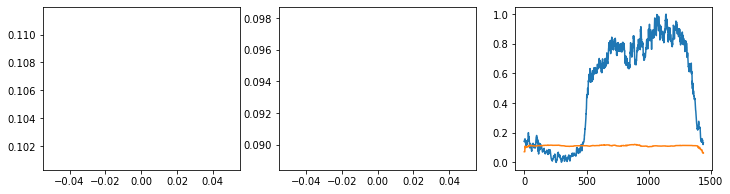

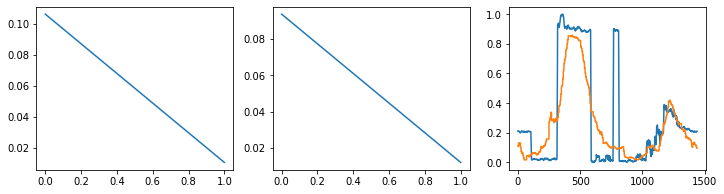

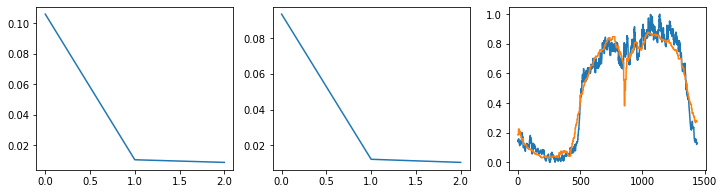

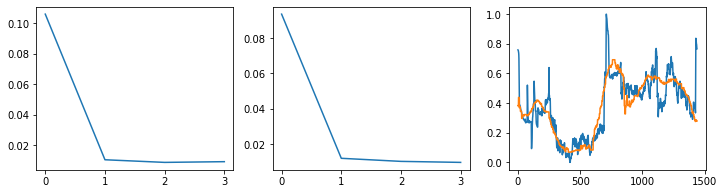

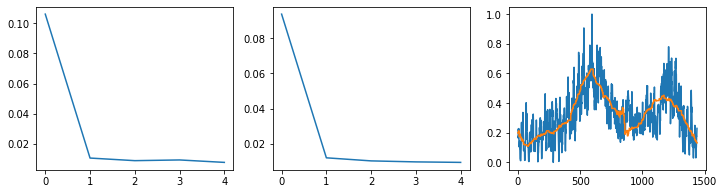

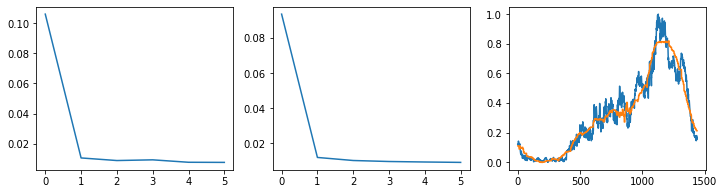

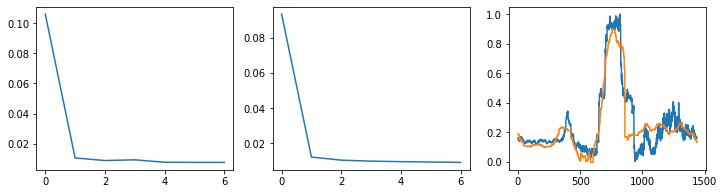

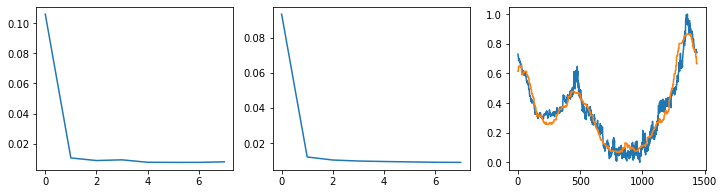

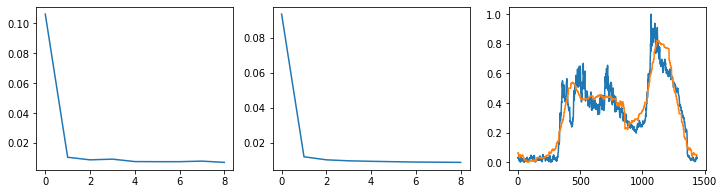

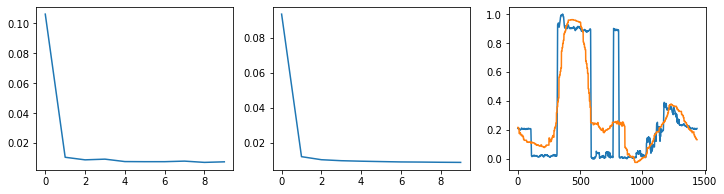

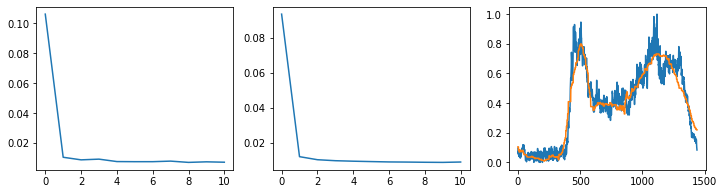

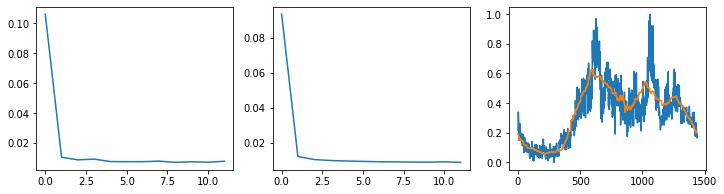

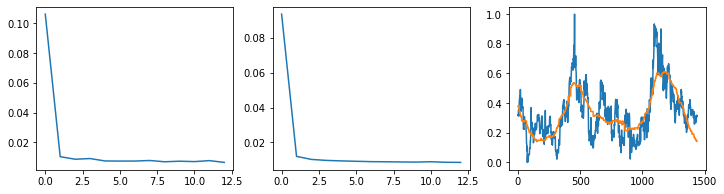

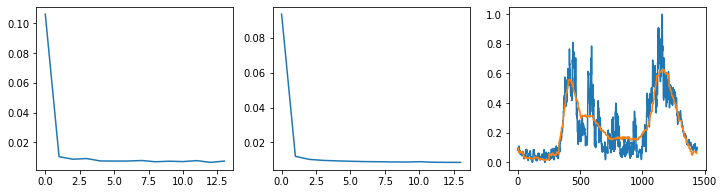

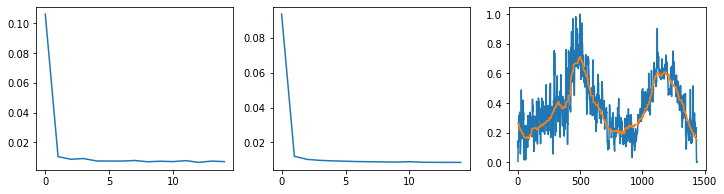

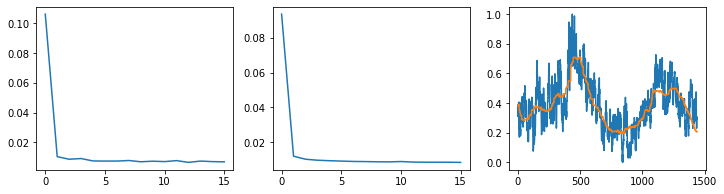

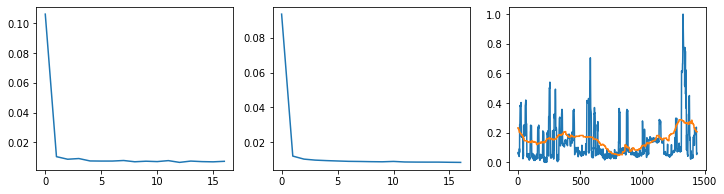

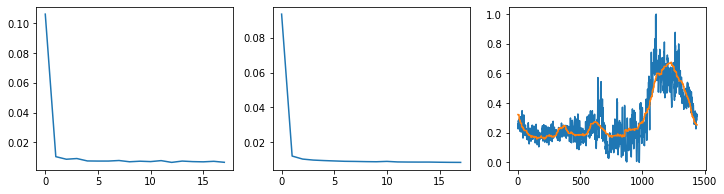

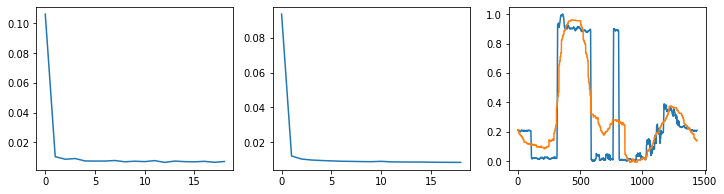

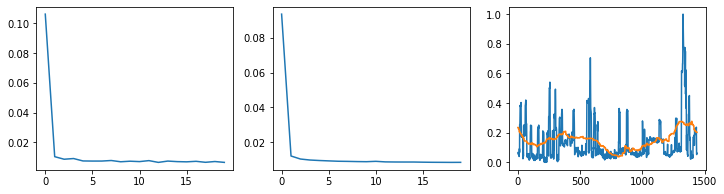

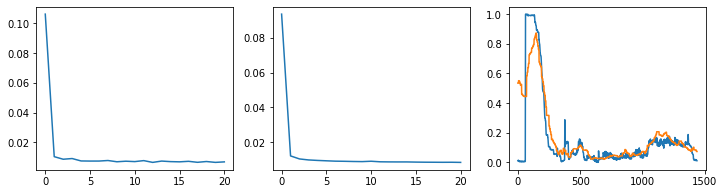

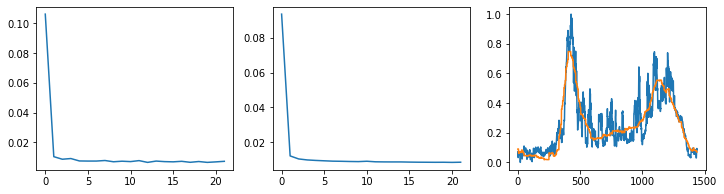

KeyboardInterrupt: 

In [1475]:
for e in range(epoch):
    for ibatch, batch in enumerate(train_loader):
        optim.zero_grad()
        latent, recon = conv_ae(batch)
        loss = loss_fn(recon, batch)
        loss.backward()
        optim.step()

    if e % 100 == 0:
        fig, axs = plt.subplots(1, 3, figsize=(12, 3))
        train_loss.append(loss.item())
        axs[0].plot(train_loss)
        # evaluate network
        with torch.no_grad():
            test_data = iter(test_loader).next()
            _, recon = conv_ae(test_data)
            loss = loss_fn(recon, test_data)
            test_loss.append(loss.item())
            axs[1].plot(test_loss)
            vis = np.random.randint(0, test_data.shape[0])
            axs[2].plot(test_data[vis][0].detach().cpu())
            axs[2].plot(recon[vis][0].detach().cpu())
            plt.show()


In [16]:
conv_ae.load_state_dict(torch.load('models/AE_CNN_d=16.pt'))

<All keys matched successfully>

In [17]:
data = train_dataset.data
data_c = data.detach().cpu().numpy()[:, 0]

In [18]:
latent, pred = conv_ae(data)
latent = latent.detach().cpu().numpy()[:, 0]
pred = pred.detach().cpu().numpy()[:, 0]

In [19]:
pred.shape

(346, 1440)

In [20]:
@widgets.interact(resident=(0, data.shape[0]-1))
def plot_normalized_daily(resident=217):
    plt.plot(data_c[resident])
    plt.plot(pred[resident])
    plt.show()
    print(latent[resident])

interactive(children=(IntSlider(value=217, description='resident', max=345), Output()), _dom_classes=('widget-…

In [21]:
from sklearn.cluster import KMeans

In [22]:
latent.shape

(346, 16)

In [23]:
clusters = 5

In [24]:
kmeans = KMeans(n_clusters=clusters, random_state=2000).fit(latent)

In [25]:
kmeans.labels_
kmeans.cluster_centers_

array([[1.4411092 , 0.15549976, 1.1038865 , 0.        , 1.3680505 ,
        1.2930219 , 1.2255535 , 1.7952033 , 0.        , 0.        ,
        0.        , 3.4082434 , 0.        , 2.2120073 , 1.3424907 ,
        0.        ],
       [1.6612104 , 0.22654411, 1.0934086 , 0.        , 1.2546061 ,
        0.9808451 , 0.84824044, 1.3150427 , 0.        , 0.        ,
        0.        , 2.5154874 , 0.        , 2.3224094 , 1.5859094 ,
        0.        ],
       [1.247768  , 0.10183122, 1.2092514 , 0.        , 1.9645005 ,
        1.3879589 , 1.0378876 , 1.299648  , 0.        , 0.        ,
        0.        , 2.46766   , 0.        , 2.3789487 , 1.1288774 ,
        0.        ],
       [2.0696433 , 0.47231328, 2.2488189 , 0.        , 1.627512  ,
        1.2157909 , 1.0086142 , 1.2697006 , 0.        , 0.        ,
        0.        , 2.4232893 , 0.        , 1.8047869 , 1.569627  ,
        0.        ],
       [1.2108597 , 0.16780877, 0.9911456 , 0.        , 0.94780624,
        0.8234283 , 0.7465647 , 

In [26]:
def decode(latent_vec: np.array, model):
    latent_tensor = torch.Tensor(latent_vec[None,:,None]).cuda()
    with torch.no_grad():
        decoded = model.decoder(latent_tensor.permute(0, 2, 1))
    return decoded.cpu().numpy()[0, 0, :]

In [29]:
@widgets.interact(Cluster=(0, clusters-1))
def plot_cluster(Cluster):
    resd = (kmeans.labels_==Cluster)
    load = data_c[resd]
    mean = load.mean(axis=0)
    centroid = kmeans.cluster_centers_[Cluster]
    decoded_mean = decode(centroid, conv_ae)
    print(f'{load.shape[0]} residents')
    plt.plot(load.T, alpha=0.03)
    plt.plot(mean, c='red')
    plt.plot(decoded_mean, c='green')
    plt.show()

interactive(children=(IntSlider(value=2, description='Cluster', max=4), Output()), _dom_classes=('widget-inter…